<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/02_GNN_message_passing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks: Message Passing and Permutation Equivariance

## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Installation](#setup-and-installation)
3. [Visualizing Message Passing](#visualize-message-passing)
4. [Understanding Permutation Equivariance](#understand-equivariance)
5. [Demonstrating Permutation Equivariance](#demonstrate-equivariance)
6. [The Kipf & Welling Graph Convolutional Network (GCN)](#gcn-paper)
7. [Conclusion](#conclusion)


## 1. Introduction <a name="introduction"></a>

### Learning Objectives
After completing this chapter, you should be able to:
- Describe what message passing is in a Graph Neural Network (GNN)
- Understand permutation equivariance and permutation invariance
- Visualize how message passing works on molecular graphs
- Explain why GNNs are suitable for molecular property prediction
- Implement a basic GNN message passing operation

### Review of Graph Theory Basics for Chemists
Before diving into GNNs, let's briefly review some graph theory concepts as they apply to chemistry:

- **Graph**: A mathematical structure consisting of nodes (vertices) and edges
- **Molecular Graph**: A representation where atoms are nodes and bonds are edges
- **Node Features**: Properties of atoms (e.g., atomic number, hybridization, formal charge)
- **Edge Features**: Properties of bonds (e.g., bond type, bond order, length)
- **Adjacency Matrix**: A matrix representation of connections between nodes

> **Key Connection**: In chemistry, we often deal with molecules where atom ordering is arbitrary. GNNs help us create models that respect this chemical reality.

### Introduction to Graph Neural Networks
A graph neural network (GNN) is a neural network with two defining attributes:

1. Its input is a graph
2. Its output is permutation equivariant

The first point is straightforward - a GNN processes data in graph format (nodes connected by edges).

But what does "permutation equivariant" mean? In our molecular context, a permutation means re-ordering our atoms (nodes). For example, in methanol, we could re-number the atoms differently. Our goal is to ensure the GNN's output changes correspondingly with these renumberings.

## 2. Setup and Installation <a name="setup-and-installation"></a>
First, we'll install the required libraries. We'll need:

RDKit: For molecular manipulation and cheminformatics
PyTorch Geometric: For graph neural network implementations
Matplotlib & Seaborn: For visualization

In [1]:
# @title install required libraries
!pip install -q rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 30.9 MB/s eta 0:00:00


In [1]:
# @title import required libraries
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
from matplotlib.animation import FuncAnimation
import numpy as np # array manipulation
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw # chemical processing
import networkx as nx # visualization
from IPython.display import HTML

## 3. Visualizing Message Passing <a name="visualize-message-passing"></a>

Message passing is the core operation in GNNs. During message passing:

1. Each node collects information from its neighbors
2. This information is transformed using learnable weights
3. The node updates its representation based on this aggregated information

> **🧪 Chemical Intuition**: Think of message passing as atoms "sensing" their local chemical environment. Just as an atom's properties are influenced by neighboring atoms in a molecule, a node in a GNN updates its features based on its graph neighborhood.

Let's visualize this process for methanol:

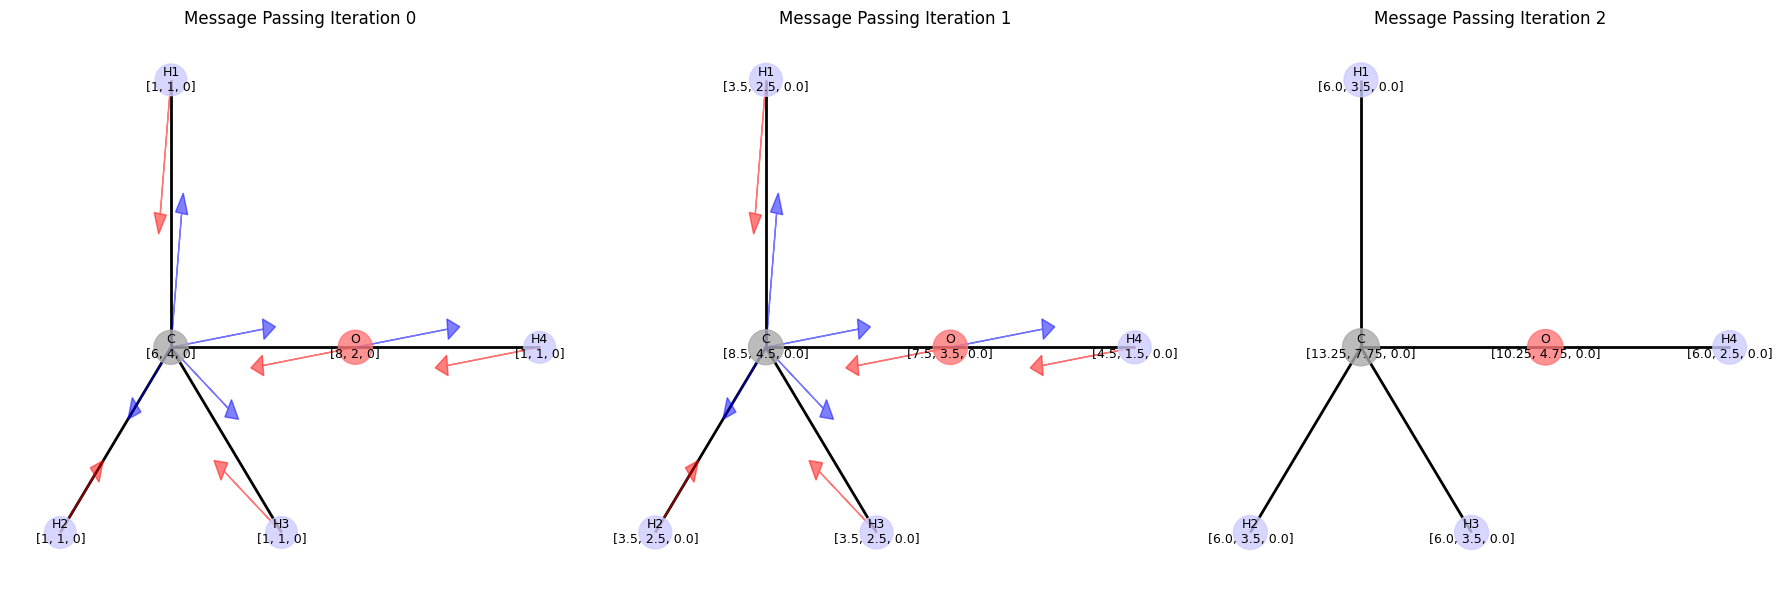

In [9]:
# Create a visualization of message passing in a molecular graph
def visualize_message_passing():
    """
    Creates an interactive visualization of message passing in a methanol molecule.
    
    This function demonstrates how information flows between atoms during the message passing
    process in a Graph Neural Network (GNN). It uses methanol (CH3OH) as an example molecule.
    
    The visualization shows:
    - Atoms as nodes with different colors (gray=Carbon, red=Oxygen, light blue=Hydrogen)
    - Chemical bonds as edges between atoms
    - Arrows showing information flow between connected atoms during message passing
    - Node features that get updated in each iteration
    
    Node features are represented as [atomic_number, valence, charge]:
    - Carbon: [6, 4, 0]  # 6 = atomic number, 4 = valence electrons, 0 = charge
    - Oxygen: [8, 2, 0]  # 8 = atomic number, 2 = valence electrons, 0 = charge
    - Hydrogen: [1, 1, 0] # 1 = atomic number, 1 = valence electron, 0 = charge
    """
    # Define 2D coordinates for each atom in methanol (CH3OH)
    # Positions are chosen to create a clear visualization of the molecular structure
    pos = {
        'C': np.array([0, 0]),      # Central carbon atom
        'O': np.array([1.5, 0]),    # Oxygen bonded to carbon
        'H1': np.array([0, 1.3]),   # First hydrogen bonded to carbon
        'H2': np.array([-0.9, -0.9]), # Second hydrogen bonded to carbon
        'H3': np.array([0.9, -0.9]), # Third hydrogen bonded to carbon
        'H4': np.array([3.0, 0])    # Hydrogen bonded to oxygen (hydroxyl)
    }

    # Define colors for each atom type following common chemical visualization conventions
    atom_colors = {
        'C': '#AAAAAA',  # gray for carbon
        'O': '#FF7777',  # red for oxygen
        'H1': '#CCCCFF', # light blue for hydrogens
        'H2': '#CCCCFF',
        'H3': '#CCCCFF',
        'H4': '#CCCCFF'
    }

    # Define initial feature vectors for each atom
    # Features: [atomic_number, valence_electrons, formal_charge]
    initial_features = {
        'C': [6, 4, 0],   # Carbon: atomic number 6, 4 valence e-, neutral
        'O': [8, 2, 0],   # Oxygen: atomic number 8, 2 valence e-, neutral
        'H1': [1, 1, 0],  # Hydrogen: atomic number 1, 1 valence e-, neutral
        'H2': [1, 1, 0],
        'H3': [1, 1, 0],
        'H4': [1, 1, 0]
    }

    # Create a molecular graph representation
    G = nx.Graph()

    # Add atoms (nodes) with their features
    for atom, features in initial_features.items():
        G.add_node(atom, features=features, layer=0)

    # Add chemical bonds (edges)
    # These represent the actual bonds in methanol: C-O, O-H, and C-H bonds
    G.add_edges_from([('C', 'O'), ('O', 'H4'), ('C', 'H1'), ('C', 'H2'), ('C', 'H3')])

    def message_passing(G, num_iterations=2, self_weight=0.5, neighbor_weight=0.5):
        """
        Simulates message passing on the molecular graph.
        
        In each iteration:
        1. Each atom collects information from its bonded neighbors
        2. Features are updated based on neighbor information
        3. This mimics how atoms "sense" their chemical environment
        
        Args:
            G (networkx.Graph): Molecular graph
            num_iterations (int): Number of message passing steps
            self_weight (float): Weight for self-influence (default=0.5)
            neighbor_weight (float): Weight for neighbor influence (default=0.5)
            
        Returns:
            list: Graphs showing state after each iteration
        """
        graphs = [G.copy()]

        for iteration in range(num_iterations):
            new_G = G.copy()

            # Update each atom's features based on its neighbors
            for node in G.nodes():
                neighbors = list(G.neighbors(node))
                neighbor_features = [G.nodes[neighbor]['features'] for neighbor in neighbors]

                if neighbor_features:
                    # Aggregate neighbor information (simple sum for demonstration)
                    aggregated = np.sum(neighbor_features, axis=0)

                    # Update features as weighted combination of:
                    # - Current atom features (self-influence)
                    # - Aggregated neighbor features (chemical environment influence)
                    old_features = np.array(G.nodes[node]['features'])
                    new_features = self_weight * old_features + neighbor_weight * aggregated
                    new_G.nodes[node]['features'] = new_features.tolist()
                    new_G.nodes[node]['layer'] = iteration + 1

            G = new_G
            graphs.append(G.copy())

        return graphs

    # Perform message passing for 2 iterations
    message_passed_graphs = message_passing(G, num_iterations=2, self_weight=0.5, neighbor_weight=0.5)

    # Visualization function for a specific iteration
    def visualize_message_passing_at_iteration(iteration, ax, show_messages=True):
        """Visualize the graph at a specific message passing iteration"""
        current_G = message_passed_graphs[iteration]
        next_G = message_passed_graphs[min(iteration+1, len(message_passed_graphs)-1)]

        # Clear the axis
        ax.clear()

        # Draw nodes with size based on feature magnitude
        sizes = []
        node_colors = []
        for node in current_G.nodes():
            # Node size based on the sum of feature values
            size = 500 + 100 * np.sum(current_G.nodes[node]['features']) / 10
            sizes.append(size)
            node_colors.append(atom_colors[node])

        # Draw the graph with the current positions
        nx.draw_networkx_nodes(current_G, pos, ax=ax, node_size=sizes, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(current_G, pos, ax=ax, width=2)

        # Draw node labels
        labels = {}
        for node in current_G.nodes():
            layer = current_G.nodes[node]['layer']
            features = [round(f, 2) for f in current_G.nodes[node]['features']]
            labels[node] = f"{node}\n{features}"

        nx.draw_networkx_labels(current_G, pos, labels=labels, font_size=9, ax=ax)

        # Show message passing arrows if requested and not at the last iteration
        if show_messages and iteration < len(message_passed_graphs) - 1:
            for edge in current_G.edges():
                source, target = edge
                source_pos, target_pos = pos[source], pos[target]

                # Draw arrows in both directions for bidirectional message passing
                # Calculate midpoints and shift slightly to avoid overlap
                mid = (source_pos + target_pos) / 2
                offset1 = np.array([0.1, 0.1])
                offset2 = np.array([-0.1, -0.1])

                # Draw arrow from source to target
                ax.arrow(source_pos[0], source_pos[1],
                        (mid + offset1)[0] - source_pos[0], (mid + offset1)[1] - source_pos[1],
                        head_width=0.1, head_length=0.1, fc='blue', ec='blue', alpha=0.5,
                        length_includes_head=True)

                # Draw arrow from target to source
                ax.arrow(target_pos[0], target_pos[1],
                        (mid + offset2)[0] - target_pos[0], (mid + offset2)[1] - target_pos[1],
                        head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.5,
                        length_includes_head=True)

        ax.set_title(f'Message Passing Iteration {iteration}')
        ax.axis('off')

    # Create a function to display multiple iterations
    def visualize_all_iterations(iterations=3):
        fig, axes = plt.subplots(1, iterations, figsize=(18, 6))

        for i in range(iterations):
            if iterations == 1:
                ax = axes
            else:
                ax = axes[i]
            visualize_message_passing_at_iteration(i, ax, show_messages=(i < iterations-1))

        plt.tight_layout()
        plt.show()

    # Display iterations 0, 1, and 2
    visualize_all_iterations(iterations=3)

    # Create an animation for a more dynamic visualization
    def create_animation():
        fig, ax = plt.subplots(figsize=(8, 6))

        def update(frame):
            ax.clear()
            visualize_message_passing_at_iteration(frame % 3, ax)
            return ax,

        ani = FuncAnimation(fig, update, frames=3, interval=1500, blit=False)
        plt.close()  # Don't display the figure
        return ani

    # Create and display the animation
    animation = create_animation()
    return HTML(animation.to_jshtml())

# Run the visualization
visualize_message_passing()

### Message Passing Operations: A Closer Look

In the animation above, we've simplified the message passing operation. In a real GNN, the message passing operation for a node `i` typically looks like:

1. **Message Creation**: Each neighbor `j` of node `i` creates a message based on its features
2. **Message Transformation**: Each message is transformed using a learnable function (often a neural network)
3. **Message Aggregation**: All messages to node `i` are combined (using sum, mean, max, etc.)
4. **Feature Update**: Node `i` updates its features based on the aggregated message and its current features

Mathematically, one iteration of message passing can be expressed as:

$$h_i^{(t+1)} = \text{UPDATE}\left(h_i^{(t)}, \text{AGGREGATE}\left(\{\text{MESSAGE}(h_i^{(t)}, h_j^{(t)}, e_{ij}) : j \in \mathcal{N}(i)\}\right)\right)$$

Where:
- $h_i^{(t)}$ is the feature vector of node $i$ at iteration $t$
- $\mathcal{N}(i)$ is the set of neighbors of node $i$
- $e_{ij}$ is the edge feature between nodes $i$ and $j$
- MESSAGE, AGGREGATE, and UPDATE are learnable functions

> **💡 Note**: Different GNN architectures use different implementations of these functions.

## 4. Understanding Permutation Equivariance <a name="understand-equivariance"></a>

Let's first understand what permutation equivariance and invariance mean:

- **Permutation Equivariance**: If you reorder the input nodes, the output changes in the same way (maintaining the correspondence).
- **Permutation Invariance**: If you reorder the input nodes, the output remains unchanged (insensitive to order).

> **Why This Matters for Chemistry**: Molecules don't have an inherent atom ordering in nature. The same molecular structure can be represented with different atom orderings, but this shouldn't affect our prediction of its properties.

When modeling **atom-level properties** (like partial charges), we need **permutation equivariance**. When modeling **molecule-level properties** (like solubility), we need **permutation invariance**.


In [10]:
# Define atomic numbers for common atoms in organic molecules
my_elements = {6: "C", 8: "O", 1: "H"}  # Carbon (6), Oxygen (8), Hydrogen (1)

def smiles2graph(sml):
    """
    Convert a SMILES string to a graph representation suitable for GNN processing.
    This function creates node features (atom types) and an adjacency tensor (bonds).

    Parameters:
    -----------
    sml : str
        SMILES representation of a molecule (e.g., "CO" for methanol)

    Returns:
    --------
    nodes : np.ndarray
        Node feature matrix with shape [num_atoms, num_atom_types]
        Each row is a one-hot encoding representing the atom type (C, O, or H)
    adj : np.ndarray
        Adjacency tensor with shape [num_atoms, num_atoms, num_bond_types+1]
        Represents bonds between atoms:
        - Channel 0: No bond
        - Channel 1: Single bond
        - Channel 2: Double bond
        - Channel 3: Triple bond
        - Channel 4: Aromatic bond
    """
    # Convert SMILES to RDKit molecule object
    m = rdkit.Chem.MolFromSmiles(sml)
    # Add explicit hydrogens - important for complete molecular representation
    m = rdkit.Chem.AddHs(m)  

    # Map RDKit bond types to integer indices
    # This mapping helps create the adjacency tensor channels
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,   # Single bond -> channel 1
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,   # Double bond -> channel 2
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,   # Triple bond -> channel 3
        rdkit.Chem.rdchem.BondType.AROMATIC: 4, # Aromatic bond -> channel 4
    }

    # Get total number of atoms including hydrogens
    N = len(list(m.GetAtoms()))

    # Create node feature matrix using one-hot encoding
    # Each row represents an atom, each column represents an atom type (C, O, H)
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        # Set the corresponding atom type to 1 in the one-hot encoding
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    # Create adjacency tensor for bonds
    # Shape: [num_atoms, num_atoms, 5] where 5 represents different bond types
    adj = np.zeros((N, N, 5))  # 5 channels: no bond + 4 bond types
    for j in m.GetBonds():
        # Get the atoms involved in the bond
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring unrecognized bond order: " + str(order))
        # Make the adjacency matrix symmetric (bonds go both ways)
        adj[u, v, order] = 1
        adj[v, u, order] = 1

    return nodes, adj

# Example: Create a graph representation for methanol (CH₃OH)
nodes, adj = smiles2graph("CO")
print(f"Node features shape: {nodes.shape}")
print(f"Adjacency matrix shape: {adj.shape}")

# Display the overall connectivity (summing over all bond types)
adj_sum = np.sum(adj, axis=2)
print("\nAdjacency matrix for methanol (1 indicates bonded atoms):")
print(adj_sum)

# Show the atom type assignments in a readable format
atom_types = ["C", "O", "H"]
print("\nNode feature matrix (rows=atoms, columns=atom types):")
for i in range(nodes.shape[0]):
    atom_type = atom_types[np.argmax(nodes[i])]
    feature_str = ", ".join([f"{val:.0f}" for val in nodes[i]])
    print(f"Atom {i} ({atom_type}): [{feature_str}]")

Node features shape: (6, 3)
Adjacency matrix shape: (6, 6, 5)

Adjacency matrix for methanol (1 indicates bonded atoms):
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]

Node feature matrix (rows=atoms, columns=atom types):
Atom 0 (C): [1, 0, 0]
Atom 1 (O): [0, 1, 0]
Atom 2 (H): [0, 0, 1]
Atom 3 (H): [0, 0, 1]
Atom 4 (H): [0, 0, 1]
Atom 5 (H): [0, 0, 1]


## Demonstrating Permutation Equivariance <a name="demonstrate-equivariance"></a>

Now, let's demonstrate permutation equivariance by showing how reordering nodes doesn't change the essential relationships:

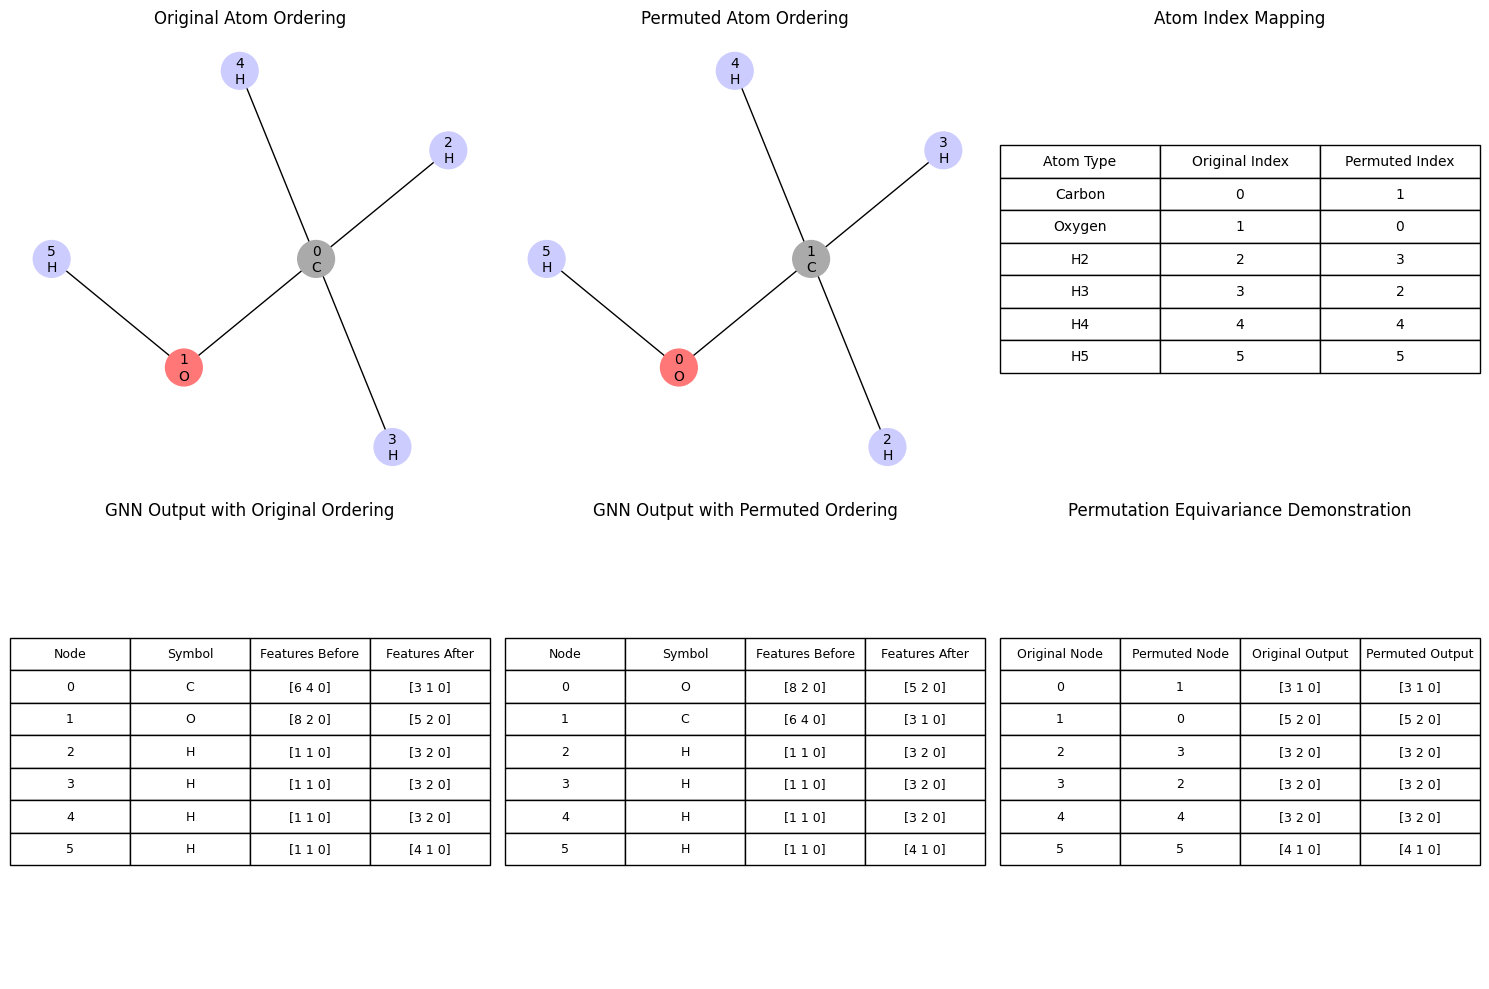


Chemical Interpretation of Permutation Equivariance:
------------------------------------------------
In chemistry, the same molecule can be written in many ways (e.g., different SMILES strings)
but should have the same chemical properties regardless of how we number the atoms.

This demonstration shows that GNNs respect this chemical principle:
1. The molecular structure remains identical despite different atom numbering
2. Chemical environments (local bonding patterns) are preserved
3. Atomic feature updates depend only on bonding patterns, not atom numbers

This is crucial for chemical applications because:
- The same molecule should always give the same predictions
- Properties should depend only on actual chemical structure
- Results should be independent of how we input the molecular structure


In [11]:
def demonstrate_permutation_equivariance():
    """
    Demonstrates permutation equivariance by showing how node features change
    when we reorder atoms, while maintaining the same structural relationships.

    This function helps chemists understand why GNNs are equivariant to atom ordering
    in molecular graphs, which is crucial since the same molecule can be represented
    with different atom orderings in chemical formats like SMILES.

    The demonstration:
    1. Creates a methanol molecule as an example
    2. Shows two different but equivalent atom orderings
    3. Applies a simple GNN layer to both orderings
    4. Visualizes how the features transform while preserving molecular structure
    """
    # Create a methanol molecule (CH3OH) - a simple example molecule 
    # that has different types of atoms and bonds
    mol = rdkit.Chem.MolFromSmiles("CO")
    # Add hydrogens explicitly since they're important for molecular structure
    mol = rdkit.Chem.AddHs(mol)

    # Define two different ways to order the atoms
    # Original ordering (typically C, O, then H's)
    original_order = list(range(mol.GetNumAtoms()))

    # Create a different but equivalent ordering by swapping atoms
    permuted_order = original_order.copy()
    # Swap carbon with oxygen - this shouldn't affect molecular properties
    permuted_order[0], permuted_order[1] = permuted_order[1], permuted_order[0]
    # Also swap some hydrogens to show that H ordering doesn't matter
    if len(permuted_order) > 3:
        permuted_order[2], permuted_order[3] = permuted_order[3], permuted_order[2]

    # Create chemical features for each atom
    # These represent atomic properties that chemists care about
    atom_features = []
    for atom in mol.GetAtoms():
        # Use chemically relevant atomic properties:
        # - Atomic number (element identity)
        # - Degree (number of bonds)
        # - Formal charge (important for reactivity)
        features = [atom.GetAtomicNum(), atom.GetDegree(), atom.GetFormalCharge()]
        atom_features.append(features)

    original_features = np.array(atom_features)

    # Create the permuted features by reordering - same info, different arrangement
    permuted_features = np.array([atom_features[i] for i in permuted_order])

    def simple_gnn_layer(features, adjacency, order):
        """
        Simple GNN layer that aggregates neighbor features.
        This mimics how atoms "see" their bonded neighbors in a molecule.

        Parameters:
        -----------
        features : np.ndarray
            Node feature matrix containing atomic properties
        adjacency : np.ndarray
            Adjacency matrix (created inside function based on molecular bonds)
        order : list
            Order of atoms to use

        Returns:
        --------
        output : np.ndarray
            Updated atomic features after considering neighboring atoms
        adj : np.ndarray
            Adjacency matrix showing bonding pattern
        """
        # Create adjacency matrix representing chemical bonds
        n = len(order)
        adj = np.zeros((n, n))

        # Fill adjacency matrix based on chemical bonds
        for bond in mol.GetBonds():
            # Convert from original atom indices to current ordering
            i = order.index(bond.GetBeginAtomIdx())
            j = order.index(bond.GetEndAtomIdx())
            # Make symmetric since chemical bonds are bidirectional
            adj[i, j] = adj[j, i] = 1

        # Message passing: Each atom updates its features based on its neighbors
        # This is analogous to how atomic properties are influenced by bonded atoms
        output = np.zeros_like(features)
        for i in range(n):
            # Find all bonded neighbors
            neighbors = [j for j in range(n) if adj[i, j] > 0]
            if neighbors:
                # Include self-interaction (atom's own properties matter)
                neighbors.append(i)
                # Average the features - simple way to combine neighbor information
                output[i] = np.mean([features[j] for j in neighbors], axis=0)
            else:
                # For isolated atoms (rare in molecules), keep original features
                output[i] = features[i]

        return output, adj

    # Apply GNN layer to both atom orderings
    original_output, original_adj = simple_gnn_layer(original_features, None, original_order)
    permuted_output, permuted_adj = simple_gnn_layer(permuted_features, None, permuted_order)

    # Verify permutation equivariance: show that reordering atoms 
    # preserves the chemical information
    permuted_back = np.zeros_like(permuted_output)
    for i, p_i in enumerate(permuted_order):
        permuted_back[p_i] = permuted_output[i]

    # Create visualization to help understand the concept
    fig = plt.figure(figsize=(15, 10))

    # 1. Original molecular structure visualization
    ax1 = plt.subplot2grid((2, 3), (0, 0))
    # Generate 2D coordinates for molecular visualization
    rdkit.Chem.rdDepictor.Compute2DCoords(mol)

    # Create a NetworkX graph for the original atom ordering
    G_orig = nx.Graph()

    # Add atoms (nodes) with their positions from RDKit
    pos_orig = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos = mol.GetConformer().GetAtomPosition(i)
        pos_orig[i] = np.array([pos.x, pos.y])
        atom_sym = atom.GetSymbol()
        G_orig.add_node(i, symbol=atom_sym, features=original_features[i])

    # Add chemical bonds as edges
    for bond in mol.GetBonds():
        G_orig.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

    # Draw the molecular graph with chemically meaningful colors
    node_labels = {i: f"{i}\n{G_orig.nodes[i]['symbol']}" for i in G_orig.nodes()}
    node_colors = ['#AAAAAA' if G_orig.nodes[i]['symbol'] == 'C' else
                   '#FF7777' if G_orig.nodes[i]['symbol'] == 'O' else
                   '#CCCCFF' for i in G_orig.nodes()]

    nx.draw_networkx(G_orig, pos=pos_orig, labels=node_labels,
                    node_color=node_colors, node_size=700, font_size=10, ax=ax1)
    ax1.set_title("Original Atom Ordering")
    ax1.axis('off')

    # 2. Permuted molecule visualization
    ax2 = plt.subplot2grid((2, 3), (0, 1))

    # Create a NetworkX graph for the permuted ordering
    G_perm = nx.Graph()

    # Add nodes with position information (permuted)
    pos_perm = {}
    for new_idx, old_idx in enumerate(permuted_order):
        pos = mol.GetConformer().GetAtomPosition(old_idx)
        pos_perm[new_idx] = np.array([pos.x, pos.y])
        atom_sym = mol.GetAtomWithIdx(old_idx).GetSymbol()
        G_perm.add_node(new_idx, symbol=atom_sym, features=permuted_features[new_idx])

    # Add edges (permuted)
    for bond in mol.GetBonds():
        old_begin = bond.GetBeginAtomIdx()
        old_end = bond.GetEndAtomIdx()
        new_begin = permuted_order.index(old_begin)
        new_end = permuted_order.index(old_end)
        G_perm.add_edge(new_begin, new_end)

    # Draw the graph
    node_labels = {i: f"{i}\n{G_perm.nodes[i]['symbol']}" for i in G_perm.nodes()}
    node_colors = ['#AAAAAA' if G_perm.nodes[i]['symbol'] == 'C' else
                   '#FF7777' if G_perm.nodes[i]['symbol'] == 'O' else
                   '#CCCCFF' for i in G_perm.nodes()]

    nx.draw_networkx(G_perm, pos=pos_perm, labels=node_labels,
                    node_color=node_colors, node_size=700, font_size=10, ax=ax2)
    ax2.set_title("Permuted Atom Ordering")
    ax2.axis('off')

    # 3. Table showing how features transform with permutation
    ax3 = plt.subplot2grid((2, 3), (0, 2))
    ax3.axis('tight')
    ax3.axis('off')

    feature_table = [
        ["Atom Type", "Original Index", "Permuted Index"],
        ["Carbon", f"{original_order.index(0)}", f"{permuted_order.index(0)}"],
        ["Oxygen", f"{original_order.index(1)}", f"{permuted_order.index(1)}"]
    ]

    for i in range(2, len(original_order)):
        atom_sym = mol.GetAtomWithIdx(i).GetSymbol()
        feature_table.append([f"{atom_sym}{i}", f"{original_order.index(i)}", f"{permuted_order.index(i)}"])

    table = ax3.table(cellText=feature_table, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax3.set_title("Atom Index Mapping")

    # 4. Original output features after GNN layer
    ax4 = plt.subplot2grid((2, 3), (1, 0))
    ax4.axis('tight')
    ax4.axis('off')

    output_headers = ["Node", "Symbol", "Features Before", "Features After"]
    output_table = []

    for i in original_order:
        atom_sym = mol.GetAtomWithIdx(i).GetSymbol()
        before = str(original_features[i])
        after = str(np.round(original_output[i], 2))
        output_table.append([str(i), atom_sym, before, after])

    table = ax4.table(cellText=output_table, colLabels=output_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax4.set_title("GNN Output with Original Ordering")

    # 5. Permuted output features after GNN layer
    ax5 = plt.subplot2grid((2, 3), (1, 1))
    ax5.axis('tight')
    ax5.axis('off')

    permuted_table = []
    for i, old_i in enumerate(permuted_order):
        atom_sym = mol.GetAtomWithIdx(old_i).GetSymbol()
        before = str(permuted_features[i])
        after = str(np.round(permuted_output[i], 2))
        permuted_table.append([str(i), atom_sym, before, after])

    table = ax5.table(cellText=permuted_table, colLabels=output_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax5.set_title("GNN Output with Permuted Ordering")

    # 6. Showing equivariance property
    ax6 = plt.subplot2grid((2, 3), (1, 2))
    ax6.axis('tight')
    ax6.axis('off')

    # Show that permuted_output[p(i)] = original_output[i]
    equiv_headers = ["Original Node", "Permuted Node", "Original Output", "Permuted Output"]
    equiv_table = []

    for orig_idx in original_order:
        perm_idx = permuted_order.index(orig_idx)
        orig_out = str(np.round(original_output[orig_idx], 2))
        perm_out = str(np.round(permuted_output[perm_idx], 2))
        equiv_table.append([str(orig_idx), str(perm_idx), orig_out, perm_out])

    table = ax6.table(cellText=equiv_table, colLabels=equiv_headers,
                      loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax6.set_title("Permutation Equivariance Demonstration")

    plt.tight_layout()
    plt.show()

    # Provide detailed chemical explanation
    print("\nChemical Interpretation of Permutation Equivariance:")
    print("------------------------------------------------")
    print("In chemistry, the same molecule can be written in many ways (e.g., different SMILES strings)")
    print("but should have the same chemical properties regardless of how we number the atoms.")
    print("\nThis demonstration shows that GNNs respect this chemical principle:")
    print("1. The molecular structure remains identical despite different atom numbering")
    print("2. Chemical environments (local bonding patterns) are preserved")
    print("3. Atomic feature updates depend only on bonding patterns, not atom numbers")
    print("\nThis is crucial for chemical applications because:")
    print("- The same molecule should always give the same predictions")
    print("- Properties should depend only on actual chemical structure")
    print("- Results should be independent of how we input the molecular structure")

# Run the demonstration
demonstrate_permutation_equivariance()

> **💡 Key insight**: Permutation equivariance is automatically satisfied by using operations like sum or average over neighbors in the message passing step. These operations don't depend on the order of neighbors, ensuring that the output transforms correctly when nodes are reordered.


## The Kipf & Welling Graph Convolutional Network (GCN) <a name="gcn-paper"></a>


One of the first popular GNNs was the Kipf & Welling graph convolutional network (GCN) [1]. Although some people consider GCNs to be a broad class of GNNs, we'll use GCNs to refer specifically to the Kipf & Welling GCN.

### GCN Layer Formulation

The input to a GCN layer is a node feature matrix (V) and an adjacency matrix (E), and it outputs an updated node feature matrix (V'). Each node feature vector is updated by averaging the feature vectors of its neighbors, as determined by E.

In mathematical form, the GCN layer operation is:

$$h_i^{(l+1)} = \sigma\left(\frac{1}{d_i} \sum_{j \in \mathcal{N}(i)} e_{ij} \cdot h_j^{(l)} \cdot W^{(l)}\right)$$

Where:
- $h_i^{(l+1)}$ is the feature vector of node $i$ at layer $l+1$
- $d_i$ is the degree of node $i$ (number of neighbors)
- $e_{ij}$ is 1 if $j$ is a neighbor of $i$, 0 otherwise
- $h_j^{(l)}$ is the feature vector of neighbor $j$ at layer $l$
- $W^{(l)}$ is a trainable weight matrix
- $\sigma$ is an activation function (commonly ReLU)

> **Chemical Intuition**: This is like an atom averaging the properties of its neighbors, but with the ability to weight different aspects of those properties differently (via the weight matrix $W^{(l)}$).

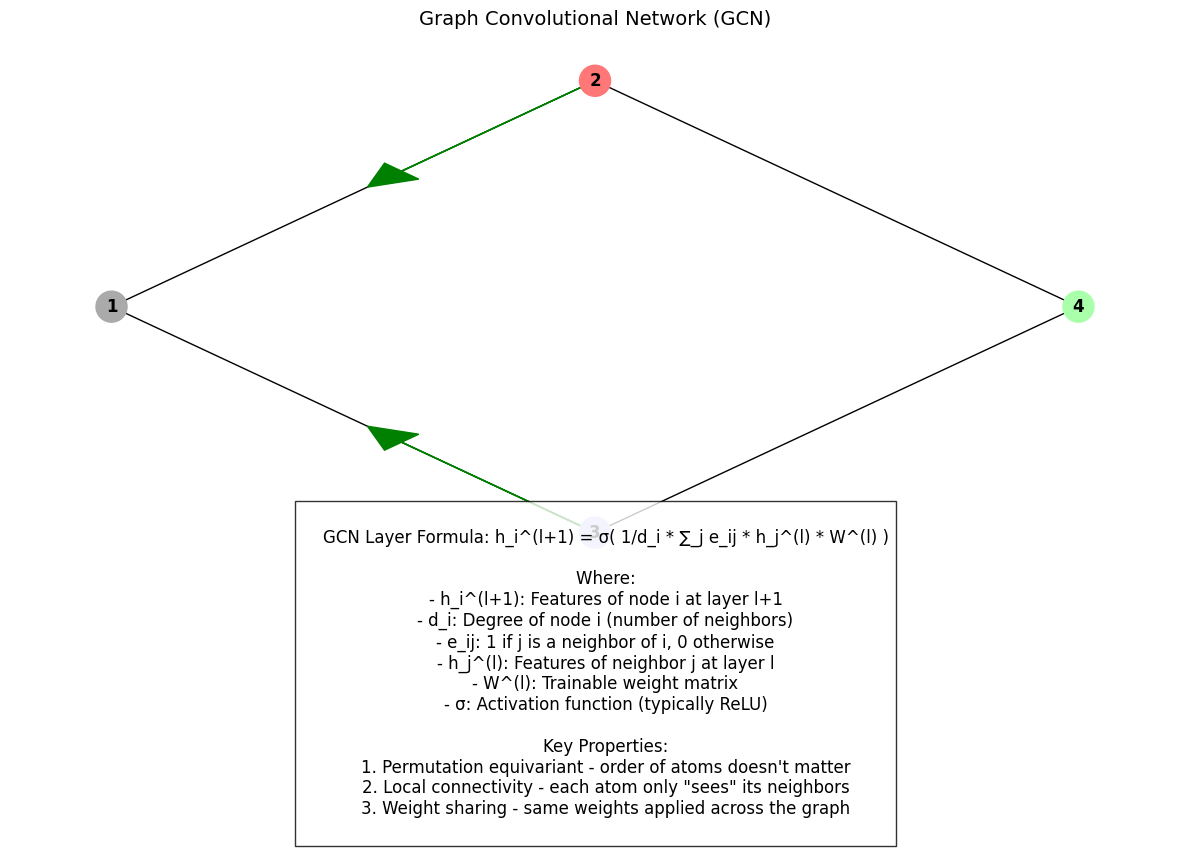

Example calculation for node 1 with 2 neighbors (nodes 2 and 3):
------------------------------------------------------------------
Feature matrix:
[[1 0 0]
 [0 1 0]
 [0 0 1]
 [1 1 0]]

Neighbor features of node 1:
Node 2: [0 1 0]
Node 3: [0 0 1]

Weight matrix W:
[[0.8 0.2 0.1]
 [0.1 0.7 0.3]
 [0.2 0.3 0.9]]

Aggregated neighbor features: [0.  0.5 0.5]
After transformation (h * W): [0.15 0.5  0.6 ]
After ReLU activation: [0.15 0.5  0.6 ]

This is the new feature vector for node 1 after one GCN layer.


In [18]:
def explain_gcn():
    """Creates a visual explanation of the GCN layer"""
    # Draw a simple graph
    fig, ax = plt.subplots(figsize=(12, 8))

    G = nx.Graph()
    G.add_nodes_from([1, 2, 3, 4])
    G.add_edges_from([(1, 2), (1, 3), (2, 4), (3, 4)])

    pos = {
        1: np.array([0, 0]),
        2: np.array([1, 1]),
        3: np.array([1, -1]),
        4: np.array([2, 0])
    }

    # Node colors to represent different atoms
    node_colors = ['#AAAAAA', '#FF7777', '#CCCCFF', '#AAFFAA']  # C, O, H, N colors

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color=node_colors, font_weight='bold', ax=ax)

    # Highlight the message passing for node 1
    # Draw arrows to show message flow from neighbors to node 1
    for neighbor in [2, 3]:
        plt.arrow(pos[neighbor][0], pos[neighbor][1],
                 (pos[1][0] - pos[neighbor][0])*0.4,
                 (pos[1][1] - pos[neighbor][1])*0.4,
                 head_width=0.1, head_length=0.1, fc='green', ec='green')

    # Add a feature matrix representation
    feature_matrix = np.array([
        [1, 0, 0],  # Node 1: Carbon
        [0, 1, 0],  # Node 2: Oxygen
        [0, 0, 1],  # Node 3: Hydrogen
        [1, 1, 0]   # Node 4: Carbon-Oxygen hybrid
    ])

    # Create a weight matrix representation
    weight_matrix = np.array([
        [0.8, 0.2, 0.1],
        [0.1, 0.7, 0.3],
        [0.2, 0.3, 0.9]
    ])

    # Add text explaining the GCN
    text = """
    GCN Layer Formula: h_i^(l+1) = σ( 1/d_i * ∑_j e_ij * h_j^(l) * W^(l) )

    Where:
    - h_i^(l+1): Features of node i at layer l+1
    - d_i: Degree of node i (number of neighbors)
    - e_ij: 1 if j is a neighbor of i, 0 otherwise
    - h_j^(l): Features of neighbor j at layer l
    - W^(l): Trainable weight matrix
    - σ: Activation function (typically ReLU)

    Key Properties:
    1. Permutation equivariant - order of atoms doesn't matter
    2. Local connectivity - each atom only "sees" its neighbors
    3. Weight sharing - same weights applied across the graph
    """

    plt.figtext(0.5, -0.1, text, ha='center', fontsize=12,
               bbox={'facecolor':'white', 'alpha':0.8, 'pad':5})

    ax.set_title("Graph Convolutional Network (GCN)", fontsize=14)
    plt.tight_layout(rect=[0, 0.2, 1, 0.95])
    plt.show()

    # Example calculation for node 1
    print("Example calculation for node 1 with 2 neighbors (nodes 2 and 3):")
    print("------------------------------------------------------------------")
    print(f"Feature matrix:\n{feature_matrix}")
    print(f"\nNeighbor features of node 1:")
    print(f"Node 2: {feature_matrix[1]}")
    print(f"Node 3: {feature_matrix[2]}")
    print(f"\nWeight matrix W:\n{weight_matrix}")

    # Calculate the new features for node 1
    neighbor_features = np.vstack([feature_matrix[1], feature_matrix[2]])
    aggregated = np.mean(neighbor_features, axis=0)

    print(f"\nAggregated neighbor features: {aggregated}")

    transformed = np.dot(aggregated, weight_matrix)
    activated = np.maximum(0, transformed)  # ReLU activation

    print(f"After transformation (h * W): {transformed}")
    print(f"After ReLU activation: {activated}")
    print("\nThis is the new feature vector for node 1 after one GCN layer.")

# Explain the GCN
explain_gcn()

### Key Features of GCNs
1. **Permutation Equivariance**: Achieved through neighbor averaging
2. **Parameter Sharing**: Same weights applied to all nodes
3. **Locality**: Only immediate neighbors influence a node's update
4. **Self-loops**: Often added to ensure a node's features influence its update

### Exercise

Now let's apply what we've learned to analyze ethanol (CCO):
1. Convert the SMILES into a graph representation
2. Visualize the graph structure
3. Perform message passing
4. Demonstrate permutation equivariance

## 7. Conclusion <a name="conclusion"></a>

In this tutorial, we've explored:

1. The concept of Graph Neural Networks (GNNs) for molecular property prediction
2. Permutation equivariance and its importance in GNNs
3. Message passing as the core mechanism behind GNNs
4. The Kipf & Welling GCN architecture
5. Applied these concepts to methanol and ethanol examples

GNNs are powerful tools for chemical property prediction because they:
- Naturally represent molecular structure
- Are invariant to atom ordering
- Can capture local and global graph structure
- Learn meaningful atom and bond representations